In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial

In [43]:
# Normal生成
def generate_adj(alphas,thetas,scale):
    num_nodes = len(alphas)
    adjacency_matrix = np.zeros((num_nodes, num_nodes))

    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            norm_diff = np.linalg.norm(thetas[i] - thetas[j])**2
            m_ij = alphas[i] + alphas[j] - norm_diff
            adjacency_matrix[i][j] = np.random.normal(loc=m_ij, scale=scale)
            adjacency_matrix[j][i] = adjacency_matrix[i][j]
    return adjacency_matrix

# fixed
def distance_matrix(point_theta):
    n = point_theta.shape[0]
    distances = np.zeros((n, n))

    for i in range(n):
        for j in range(i+1, n):
            dist = np.linalg.norm(point_theta[i] - point_theta[j])**2
            distances[i, j] = dist
            distances[j, i] = dist
    return distances

# fixed
def generate_M_matrix(alphas, thetas):
    num_nodes = len(alphas)
    M = np.zeros((num_nodes, num_nodes))
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            norm_squared = np.linalg.norm(thetas[i] - thetas[j]) ** 2
            M[i][j] = alphas[i] + alphas[j] - norm_squared
            M[j][i] = M[i][j]
    return M

# Normal生成
def f(A, alphas, thetas, scale):
    M = generate_M_matrix(alphas, thetas)
    num_nodes = A.shape[0]
    result = 0
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                result += (A[i][j]*M[i][j] - 0.5*M[i][j]**2)/scale - A[i][j]**2/(2*scale)-0.5*np.log(2*np.pi*scale)
    return result

def Projection(X,C):
    return X if np.linalg.norm(X) < C else C*X/np.linalg.norm(X)

def gradient_theta(A, alphas, thetas, scale):
    num_nodes = len(alphas)
    gradient = np.zeros_like(thetas)

    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                norm_squared = np.linalg.norm(thetas[i] - thetas[j]) ** 2
                term = alphas[i] + alphas[j] - norm_squared
                # sigmoid_term = sigmoid(alphas[i] + alphas[j] - norm_squared)
                gradient[i] += (-2*(A[i][j]- term)*(thetas[i] - thetas[j]))/scale

    return gradient

def gradient_alpha(A, alphas, thetas, scale):
    num_nodes = len(alphas)
    gradient = np.zeros_like(alphas)
    
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                norm_squared = np.linalg.norm(thetas[i] - thetas[j]) ** 2
                term = alphas[i] + alphas[j] - norm_squared
                # sigmoid_term = sigmoid(alphas[i] + alphas[j] - norm_squared)
                gradient[i] += (A[i][j]- term)/scale
    
    return gradient

In [44]:
def main(num_samples, k, C, learning_rate, learning_rate_, tolerace, scale):
    # Generate alpha theta
    true_alpha = np.random.rand(num_samples)
    true_theta = np.random.uniform(-45*np.pi/161, 45*np.pi/161, num_samples*k).reshape(num_samples,-1)
    # true_theta = np.random.uniform(0, 1, num_samples*k).reshape(num_samples,-1)

    # Generate adjacency matrix
    adjacency_matrix = generate_adj(true_alpha, true_theta, scale)

    # Generate distance matrix
    distance_matrix_ = distance_matrix(true_theta)
    
    pred_alpha = np.random.rand(num_samples)
    pred_theta = np.random.uniform(-45*np.pi/161, 45*np.pi/161, num_samples*k).reshape(num_samples,-1)
    # pred_theta = np.random.uniform(0, 1, num_samples*k).reshape(num_samples,-1)

    logli = f(adjacency_matrix, pred_alpha, pred_theta, scale)
    avg_loss_theta = []
    avg_loss_alpha = []
    max_loss_theta = []
    max_loss_alpha = []
    logli_list = []
    
    # Learning rate adjustment variables
    decay_rate = 0.9  
    min_learning_rate = learning_rate_

    flag = True
    iter = 0
    while flag:
        iter += 1
        # update theta
        grad_y = gradient_theta(adjacency_matrix, pred_alpha, pred_theta, scale)
        prev_theta = pred_theta
        pred_theta = Projection(pred_theta + learning_rate*grad_y, C)
        diff_distance = distance_matrix_-distance_matrix(pred_theta)
        avg_loss_theta.append(np.linalg.norm(diff_distance, ord='fro')**2/len(pred_theta)**2)
        max_loss_theta.append(np.abs(diff_distance).max())  

        # update alpha
        grad_x = gradient_alpha(adjacency_matrix, pred_alpha, pred_theta, scale)
        prev_alpha = pred_alpha
        pred_alpha = Projection(pred_alpha + learning_rate*grad_x, C)
        diff_alpha = true_alpha-pred_alpha
        avg_loss_alpha.append(np.linalg.norm(diff_alpha)**2/len(pred_alpha))
        max_loss_alpha.append(np.abs(diff_alpha).max())

        prev_logli = logli
        logli = f(adjacency_matrix, pred_alpha, pred_theta, scale)
        logli_list.append(prev_logli)

        if (logli-prev_logli)/np.abs(prev_logli) < tolerace:
            flag = False

        # Update the learning rate
        learning_rate = max(min_learning_rate, learning_rate * decay_rate)

    return avg_loss_alpha, avg_loss_theta, max_loss_alpha, max_loss_theta, logli_list

In [ ]:
def main_(num_samples, k, C, learning_rate, learning_rate_, scale):
    # Generate alpha theta
    true_alpha = np.random.rand(num_samples)
    true_theta = np.random.uniform(-45*np.pi/161, 45*np.pi/161, num_samples*k).reshape(num_samples,-1)
    # true_theta = np.random.uniform(0, 1, num_samples*k).reshape(num_samples,-1)

    # Generate adjacency matrix
    adjacency_matrix = generate_adj(true_alpha, true_theta, scale)

    # Generate distance matrix
    distance_matrix_ = distance_matrix(true_theta)
    
    pred_alpha = np.random.rand(num_samples)
    pred_theta = np.random.uniform(-45*np.pi/161, 45*np.pi/161, num_samples*k).reshape(num_samples,-1)
    # pred_theta = np.random.uniform(0, 1, num_samples*k).reshape(num_samples,-1)

    logli = f(adjacency_matrix, pred_alpha, pred_theta, scale)
    avg_loss_theta = []
    avg_loss_alpha = []
    max_loss_theta = []
    max_loss_alpha = []
    logli_list = []
    
    # Learning rate adjustment variables
    decay_rate = 0.9  
    min_learning_rate = learning_rate_

    for i in range(10):
        # update theta
        grad_y = gradient_theta(adjacency_matrix, pred_alpha, pred_theta, scale)
        prev_theta = pred_theta
        pred_theta = Projection(pred_theta + learning_rate*grad_y, C)
        diff_distance = distance_matrix_-distance_matrix(pred_theta)
        avg_loss_theta.append(np.linalg.norm(diff_distance, ord='fro')**2/len(pred_theta)**2)
        max_loss_theta.append(np.abs(diff_distance).max())  

        # update alpha
        grad_x = gradient_alpha(adjacency_matrix, pred_alpha, pred_theta, scale)
        prev_alpha = pred_alpha
        pred_alpha = Projection(pred_alpha + learning_rate*grad_x, C)
        diff_alpha = true_alpha-pred_alpha
        avg_loss_alpha.append(np.linalg.norm(diff_alpha)**2/len(pred_alpha))
        max_loss_alpha.append(np.abs(diff_alpha).max())

        prev_logli = logli
        logli = f(adjacency_matrix, pred_alpha, pred_theta, scale)
        logli_list.append(prev_logli)

        # Update the learning rate
        learning_rate = max(min_learning_rate, learning_rate * decay_rate)

    return avg_loss_alpha, avg_loss_theta, max_loss_alpha, max_loss_theta, logli_list

In [45]:
# np.random.seed(2)
scale = 1
num_samples = 200
k = 2
C = 10000
learning_rate = 0.0001
learning_rate_ = 0.0001
tolerace = 0.0001

avg_loss_alpha, avg_loss_theta, max_loss_alpha, max_loss_theta, logli_list = main(num_samples, k, C, learning_rate, learning_rate_, tolerace, scale)
# avg_loss_alpha, avg_loss_theta, max_loss_alpha, max_loss_theta, logli_list = main_(num_samples, k, C, learning_rate, learning_rate_, tolerace, scale)

In [46]:
relative_errors = []

for i in range(1, len(logli_list)):
    relative_error = (logli_list[i] - logli_list[i-1])/abs(logli_list[i-1])
    relative_errors.append(relative_error)

print(relative_errors)

[0.03323609808481898, 0.025283714656056937, 0.020166816063287605, 0.016668277630759076, 0.014156661996969544, 0.012277646402529891, 0.01082111744439133, 0.009657104217605213, 0.008702409327577288, 0.007902198861246351, 0.007219377601462558, 0.00662823046410661, 0.006110502030480939, 0.0056529191096739255, 0.005245593071140495, 0.004880972194987049, 0.004553145227171287, 0.0042573731298841035, 0.003989771175962316, 0.0037470911477791033, 0.0035265706934741957, 0.003325827960934672, 0.0031427868474078703, 0.0029756229883565978, 0.002822723819082568, 0.002682658215906144, 0.0025541526993847, 0.0024360721870843997, 0.0023274039628949235, 0.0022272439866971535, 0.0021347849735050776, 0.002049305868547418, 0.001970162473806819, 0.0018967790607384196, 0.0018286408525393953, 0.0017652872884684743, 0.0017063059980682565, 0.0016513274230378317, 0.0016000200289197665, 0.0015520860524859041, 0.0015072577330898394, 0.00146529397905936, 0.0014259774227457472, 0.0013891118213724286, 0.001354519764201

In [47]:
len(relative_errors)

322

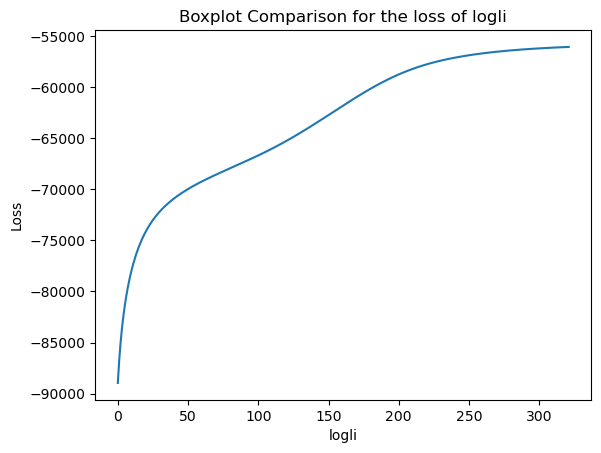

In [48]:
plt.plot(logli_list[1:])
plt.title(fr'Boxplot Comparison for the loss of logli')
plt.xlabel('logli')
plt.ylabel('Loss')
plt.show()

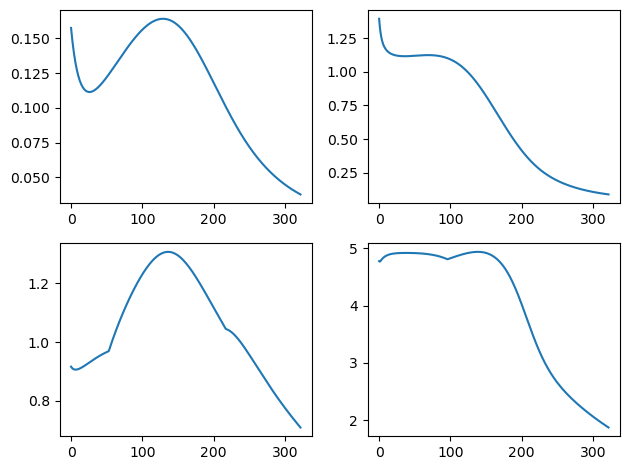

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# 定义四个列表的数据
avg_loss_alpha, avg_loss_theta, max_loss_alpha, max_loss_theta

# 创建一个 2x2 的子图布局
fig, axs = plt.subplots(2, 2)

# 绘制每个子图的线图
axs[0, 0].plot(avg_loss_alpha)
axs[0, 1].plot(avg_loss_theta)
axs[1, 0].plot(max_loss_alpha)
axs[1, 1].plot(max_loss_theta)

# 调整子图的布局和样式
plt.tight_layout()

# 显示图形
plt.show()